## 2.2. Aprendizaje automático (Clasificación)

En este apartado, crearemos y entrenaremos cuatro modelos de clasificación: Árbol de decisión, Regresión logística, Random Forest, y Gradient Boosting. Aplicaremos técnicas de validación cruzada (K-folds) para cada uno de los modelos y así poder obtener una evaluación promedio que nos ayude a escoger el modelo que mejor se comporte con datos no vistos. 

Posteriormente, realizaremos un ajuste de hiperparámetros con GridSearchCV para obtener los mejores parámetros del mejor modelo esogido anteriormente. 

En definitiva, resumimos los pasos a seguir:

         2.2.1 - División del set de datos en entrenamiento y prueba
         
         2.2.2 - Modelos de Regresión Logística, Árbol de decisión, Random Forest y Gradient Boosting
         
         2.2.3 - Validación cruzada
         
         2.2.4 - Ajuste de hiperparámetros

         2.2.5 - Conclusión de resultados

In [88]:
#Librerías a utilizar
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
#Importamos el set de datos tratado en el proceso anterior '02. Limpieza y manipulación de datos'
jb = pd.read_csv('./dataset/Cleaned_job_position_CLASSIFICATION.csv')

Las categorías que trataremos de clasificar serán las siguientes:

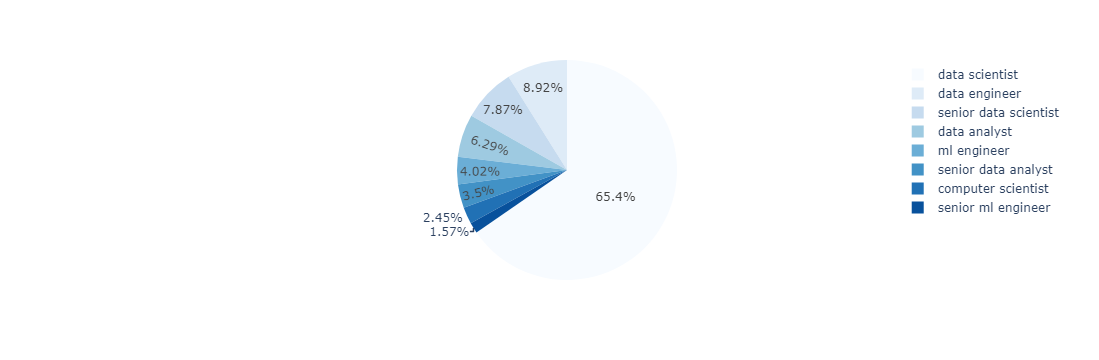

In [90]:
job_desc_count = jb['job_desc'].value_counts().reset_index()
fig = px.pie(job_desc_count, 
             names='job_desc', 
             values='count',
             color_discrete_sequence=px.colors.sequential.Blues)

# Mostrar el gráfico
fig.show()

## Conversión de variables categóricas a numéricas.

Antes de comenzar a entrar nuestros modelos, haremos una conversión de variables categóricas a numéricas. Actualmente disponemos de 5 columnas categóricas que tenemos que transformar y ver si son determinantes para explicar nuestra variable de clasificación a predecir, 'job_desc'.

In [91]:
jb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Size               572 non-null    object
 1   Type of ownership  572 non-null    object
 2   Sector             572 non-null    object
 3   Revenue            572 non-null    object
 4   avg_salary         572 non-null    int64 
 5   company_age        572 non-null    int64 
 6   job_desc           572 non-null    object
 7   Python             572 non-null    int64 
 8   Excel              572 non-null    int64 
 9   Hadoop             572 non-null    int64 
 10  Spark              572 non-null    int64 
 11  AWS                572 non-null    int64 
 12  BI Tools           572 non-null    int64 
 13  SQL                572 non-null    int64 
 14  Git                572 non-null    int64 
dtypes: int64(10), object(5)
memory usage: 67.2+ KB


In [92]:
columnas_categoricas = jb.select_dtypes(include=['object']).columns
print(columnas_categoricas)

Index(['Size', 'Type of ownership', 'Sector', 'Revenue', 'job_desc'], dtype='object')


In [93]:
#Librerías que utilizaremos para transformar las varibles categóricas a numéricas
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


Utilizaremos LabelEncoder para las variables que no siguen un orden natural.
 * job_desc
 * Type of ownership
 * Sector

In [94]:
#Definimos las columnas categóricas
columnas_categoricas_le = columnas_categoricas.drop(['Size', 'Revenue'])

# Inicializar el LabelEncoder
le = LabelEncoder()

# Crear una copia del DataFrame para almacenar los resultados
jb_encoded = jb.copy()

# Crear un diccionario para almacenar el mapeo de cada columna categórica
mapeo_categorias_le = {}

# Convertir cada columna categórica en números y guardar el mapeo
for col in columnas_categoricas_le:
    jb_encoded[col] = le.fit_transform(jb_encoded[col]) + 1  # Agregar 1 para comenzar desde 1
    # Guardar el mapeo en el diccionario
    mapeo_categorias_le[col] = dict(zip(le.classes_, le.transform(le.classes_) + 1))

# Verificar el resultado
print(jb_encoded.head())



                      Size  Type of ownership  Sector  \
0   1001 to 5000 employees                  4       8   
1  5001 to 10000 employees                  2       3   
2   1001 to 5000 employees                  1       3   
3    501 to 1000 employees                  2       9   
4      51 to 200 employees                  1       3   

                      Revenue  avg_salary  company_age  job_desc  Python  \
0    Unknown / Non-Applicable         154           27         7       6   
1      $1 to $2 billion (USD)         154           52         4       3   
2  $100 to $500 million (USD)         154           39         4       3   
3  $100 to $500 million (USD)         154           20         4       3   
4    Unknown / Non-Applicable         154           22         4       3   

   Excel  Hadoop  Spark  AWS  BI Tools  SQL  Git  
0      5       5      3    4         3    6    3  
1      4       1      2    3         1    4    1  
2      4       2      2    1         2    2    

In [95]:
#Guardamos la transormación de las varibles categóricas en un diccionario
mapeo_categorias_le

{'Type of ownership': {'Company - Private': 1,
  'Company - Public': 2,
  'Government': 3,
  'Nonprofit Organization': 4,
  'Others': 5,
  'Subsidiary or Business Segment': 6},
 'Sector': {'Aerospace & Defense': 1,
  'Biotech & Pharmaceuticals': 2,
  'Business Services': 3,
  'Finance': 4,
  'Government': 5,
  'Health Care': 6,
  'Information Technology': 7,
  'Insurance': 8,
  'Manufacturing': 9,
  'Oil, Gas, Energy & Utilities': 10,
  'Unknown': 11},
 'job_desc': {'computer scientist': 1,
  'data analyst': 2,
  'data engineer': 3,
  'data scientist': 4,
  'ml engineer': 5,
  'senior data analyst': 6,
  'senior data scientist': 7,
  'senior ml engineer': 8}}

Utilizaremos OrdinalEncoder para las variables que no siguen un orden natural.

* Size
* Revenue

In [96]:
# Definir el orden de las categorías manualmente
size_order = [
    'Unknown',
    '1 to 50 employees',
    '51 to 200 employees',
    '201 to 500 employees',
    '501 to 1000 employees',
    '1001 to 5000 employees',
    '5001 to 10000 employees',
    '10000+ employees'
]

revenue_order = [
    'Unknown / Non-Applicable',
    'Less than $1 million (USD)',
    '$1 to $5 million (USD)',
    '$5 to $10 million (USD)',
    '$10 to $25 million (USD)',
    '$25 to $50 million (USD)',
    '$50 to $100 million (USD)',
    '$100 to $500 million (USD)',
    '$500 million to $1 billion (USD)',
    '$1 to $2 billion (USD)',
    '$2 to $5 billion (USD)',
    '$5 to $10 billion (USD)',
    '$10+ billion (USD)'
]


In [97]:
# Crear el OrdinalEncoder con el orden especificado
encoder = OrdinalEncoder(categories=[size_order, revenue_order])

# Aplicar el encoder a las columnas 'Size' y 'Revenue'
jb_encoded[['Size', 'Revenue']] = encoder.fit_transform(jb_encoded[['Size', 'Revenue']]).astype(int)

# Diccionario con el nuevo código y la descripción original
size_mapeo = {idx: categoria for idx, categoria in enumerate(size_order)}
revenue_mapeo = {idx: categoria for idx, categoria in enumerate(revenue_order)}

# Almacenar ambos en un diccionario general
mapeo_categorias_oe = {
    'Size': size_mapeo,
    'Revenue': revenue_mapeo
}
# Verificar el resultado
print(jb_encoded.head())

   Size  Type of ownership  Sector  Revenue  avg_salary  company_age  \
0     5                  4       8        0         154           27   
1     6                  2       3        9         154           52   
2     5                  1       3        7         154           39   
3     4                  2       9        7         154           20   
4     2                  1       3        0         154           22   

   job_desc  Python  Excel  Hadoop  Spark  AWS  BI Tools  SQL  Git  
0         7       6      5       5      3    4         3    6    3  
1         4       3      4       1      2    3         1    4    1  
2         4       3      4       2      2    1         2    2    2  
3         4       3      4       2      2    3         1    4    3  
4         4       3      4       1      1    2         2    2    2  


In [98]:
mapeo_categorias_oe

{'Size': {0: 'Unknown',
  1: '1 to 50 employees',
  2: '51 to 200 employees',
  3: '201 to 500 employees',
  4: '501 to 1000 employees',
  5: '1001 to 5000 employees',
  6: '5001 to 10000 employees',
  7: '10000+ employees'},
 'Revenue': {0: 'Unknown / Non-Applicable',
  1: 'Less than $1 million (USD)',
  2: '$1 to $5 million (USD)',
  3: '$5 to $10 million (USD)',
  4: '$10 to $25 million (USD)',
  5: '$25 to $50 million (USD)',
  6: '$50 to $100 million (USD)',
  7: '$100 to $500 million (USD)',
  8: '$500 million to $1 billion (USD)',
  9: '$1 to $2 billion (USD)',
  10: '$2 to $5 billion (USD)',
  11: '$5 to $10 billion (USD)',
  12: '$10+ billion (USD)'}}

El set de datos con el que trabajaremos quedará así.

In [99]:
jb_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Size               572 non-null    int64
 1   Type of ownership  572 non-null    int64
 2   Sector             572 non-null    int64
 3   Revenue            572 non-null    int64
 4   avg_salary         572 non-null    int64
 5   company_age        572 non-null    int64
 6   job_desc           572 non-null    int64
 7   Python             572 non-null    int64
 8   Excel              572 non-null    int64
 9   Hadoop             572 non-null    int64
 10  Spark              572 non-null    int64
 11  AWS                572 non-null    int64
 12  BI Tools           572 non-null    int64
 13  SQL                572 non-null    int64
 14  Git                572 non-null    int64
dtypes: int64(15)
memory usage: 67.2 KB


## Modelado, predicción y evaluación

In [100]:
#Definimos una semilla para poder replicar el proceso 
seed=17

### 2.2.1. División del set de datos en conjuntos de train (70%) y de test (30%).

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

En este apartado, dividiremos nuestro set de datos en 70% para entrenamiento y 30% para test. Escogemos un 30% en lugar de un 20% debido a que tenemos pocos datos. 
Además, estandarizaremos nuestros datos para poder comprobar como afecta al rendimiento de nuestros modelos. Para estandarizarlos, utilizaremos RobustScaler dado que es más robusto frente a los outliers, estandariza los datos en base a la mediana y el IQR, en comparación del StandarScaler que lo hace con la media y la desviación estándard pero es muy sensible a los outliers.

In [102]:
#Separamos nuestra variables características de nuestra variable objetivo
X = jb_encoded.drop(columns=['job_desc'])
y = jb_encoded['job_desc']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Inicializamos el RobustScaler para el estadarizado de datos
scaler = RobustScaler()

# Ajustamos el scaler en los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(400, 14) (172, 14) (400,) (172,)


In [103]:
#Definimos una función para la matriz de confusión como método de evaluación visual de cada modelo
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

def plot_confusion_matrix(y, y_pred):
    # Extraer el mapeo de etiquetas y sus índices
    mapeo = mapeo_categorias_le['job_desc']
    
    # Invertir el diccionario para mapear índices a etiquetas
    etiquetas = {v: k for k, v in mapeo.items()}
    
    # Generar la matriz de confusión
    cm = metrics.confusion_matrix(y, y_pred)
    
    # Configurar la figura y el tamaño
    plt.figure(figsize=(8, 6))
    
    # Mostrar la matriz de confusión como una imagen de colores
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.colorbar()  # Mostrar la barra de colores que representa los valores
    
    # Configurar etiquetas de los ejes x e y usando el diccionario invertido
    classes = sorted(etiquetas.keys())
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, [etiquetas[i] for i in classes], rotation=45)
    plt.yticks(tick_marks, [etiquetas[i] for i in classes])
    
    # Agregar números como anotaciones de texto en cada celda
    threshold = cm.max() / 2.  # Umbral para decidir el color del texto
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")
    
    # Ajustar el diseño para mejorar la legibilidad
    plt.tight_layout()
    
    # Etiquetas de los ejes y título
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

### 2.2.2. Modelo Regresión logística

En primer lugar, entrenaremos un modelo de regresión logística con todas las variables de nuestro set de datos. En este caso, dado que este modelo es sensible a la escala de las características, realizaremos pruebas con datos originales y con datos escalados.

In [104]:
from sklearn.linear_model import LogisticRegression

Rendimiento del modelo de regresión logística en el conjunto de entrenamiento: 0.9775
Rendimiento del modelo de regresión logística en el conjunto de prueba: 0.8837209302325582
Informe de clasificación:
              precision    recall  f1-score   support

           1       0.29      0.67      0.40         3
           2       0.91      0.91      0.91        11
           3       0.76      0.73      0.74        22
           4       0.94      0.99      0.97       102
           5       0.60      0.30      0.40        10
           6       1.00      0.57      0.73         7
           7       1.00      0.93      0.96        14
           8       0.75      1.00      0.86         3

    accuracy                           0.88       172
   macro avg       0.78      0.76      0.75       172
weighted avg       0.89      0.88      0.88       172



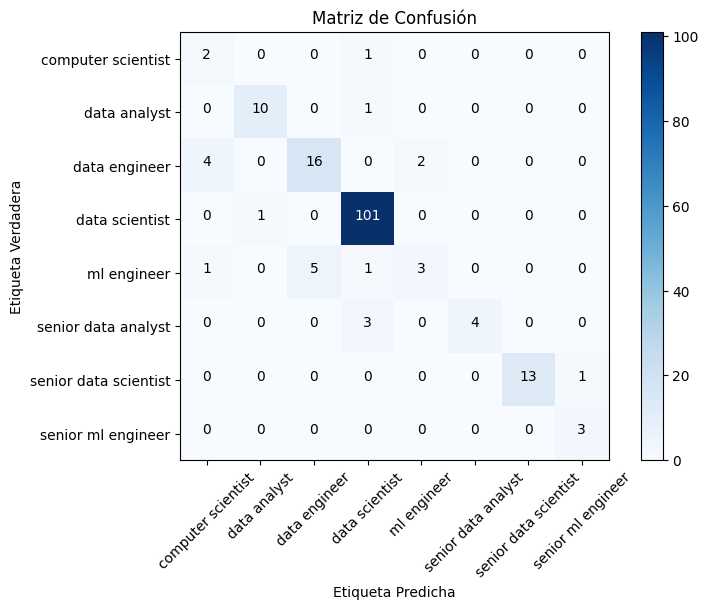

In [105]:
# Inicializamos el modelo de regresión logística
logistic_regression_model = LogisticRegression(random_state=seed, max_iter=8000)

# Ajustamos el modelo a los datos de entrenamiento
logistic_regression_model.fit(X_train, y_train)

# Calculamos el rendimiento del modelo de regresión logística en el conjunto de entrenamiento
score_logistic = logistic_regression_model.score(X_train, y_train)
print(f"Rendimiento del modelo de regresión logística en el conjunto de entrenamiento: {score_logistic:.4f}")

# Predecimos las etiquetas en el conjunto de prueba
y_pred_lr = logistic_regression_model.predict(X_test)

# Calculamos la puntuación de precisión
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Rendimiento del modelo de regresión logística en el conjunto de prueba: {accuracy_lr}")

# Imprimimos un informe de clasificación detallado
print("Informe de clasificación:")
print(classification_report(y_test, y_pred_lr))

# Mostramos la matriz de confusión
conf_matrix_lr = plot_confusion_matrix(y_test, y_pred_lr)



#### Con datos escalados

Rendimiento del modelo de regresión logística en el conjunto de entrenamiento: 0.9625
Rendimiento del modelo de regresión logística en el conjunto de prueba: 0.9011627906976745
Informe de clasificación:
              precision    recall  f1-score   support

           1       0.29      0.67      0.40         3
           2       1.00      0.91      0.95        11
           3       0.81      0.77      0.79        22
           4       0.93      1.00      0.96       102
           5       1.00      0.40      0.57        10
           6       1.00      0.57      0.73         7
           7       1.00      0.93      0.96        14
           8       1.00      1.00      1.00         3

    accuracy                           0.90       172
   macro avg       0.88      0.78      0.80       172
weighted avg       0.92      0.90      0.90       172



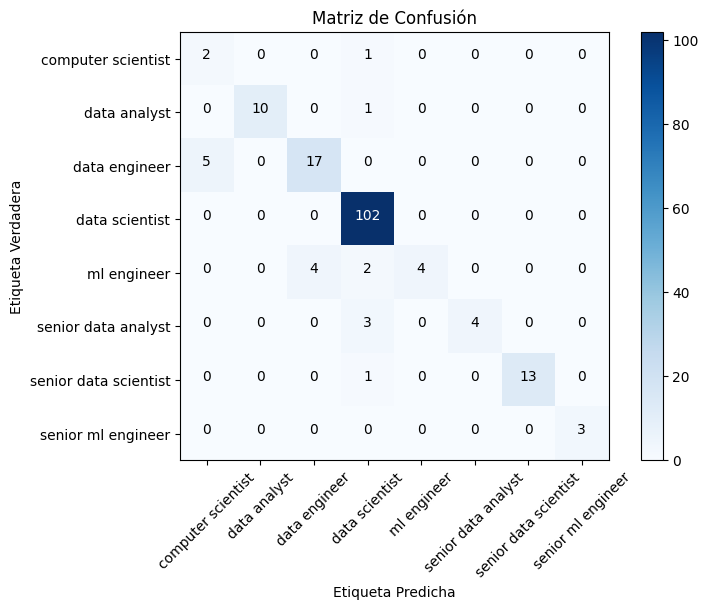

In [106]:
# Ajustamos el modelo a los datos de entrenamiento escalados
logistic_regression_model.fit(X_train_scaled, y_train)

# Calculamos el rendimiento del modelo de regresión logística en el conjunto de entrenamiento escalado
score_logistic_scaled = logistic_regression_model.score(X_train_scaled, y_train)
print(f"Rendimiento del modelo de regresión logística en el conjunto de entrenamiento: {score_logistic_scaled:.4f}")

# Predecimos las etiquetas en el conjunto de prueba escalados
y_pred_lr_scaled = logistic_regression_model.predict(X_test_scaled)

# Calculamos la puntuación de precisión
accuracy_lr_scaled = accuracy_score(y_test, y_pred_lr_scaled)
print(f"Rendimiento del modelo de regresión logística en el conjunto de prueba: {accuracy_lr_scaled}")

# Imprimimos un informe de clasificación detallado
print("Informe de clasificación:")
print(classification_report(y_test, y_pred_lr_scaled))

# Mostramos la matriz de confusión
conf_matrix_lr_scaled = plot_confusion_matrix(y_test, y_pred_lr_scaled)


Obervamos como el modelo de regresión logística predice mejor con los datos escalados, mejorando así los valores acertados tal y como vemos en la comparación de las matrices de confusión.

* Se ha mejorado la predicción en las categorías: data engineer, data scientist y ml engineer. 

### 2.2.2 Modelo de Árbol de decisión

En segundo lugar, entrenaremos un modelo de árbol de decisión de clasificación con todas las variables de nuestro set de datos. En este caso no entrenaremos el modelo de datos con datos escalados dado que el árbol de decisión no es sensible a ellos.

In [107]:
from sklearn.tree import DecisionTreeClassifier

#### Con datos originales

Rendimiento del modelo de árbol de decisión en el conjunto de entrenamiento: 1.0000
Rendimiento del modelo de árbol de decisión en el conjunto de prueba: 0.877906976744186
Informe de clasificación:
              precision    recall  f1-score   support

           1       0.14      0.33      0.20         3
           2       0.85      1.00      0.92        11
           3       0.72      0.59      0.65        22
           4       0.99      0.99      0.99       102
           5       0.38      0.30      0.33        10
           6       1.00      0.71      0.83         7
           7       1.00      1.00      1.00        14
           8       0.60      1.00      0.75         3

    accuracy                           0.88       172
   macro avg       0.71      0.74      0.71       172
weighted avg       0.89      0.88      0.88       172



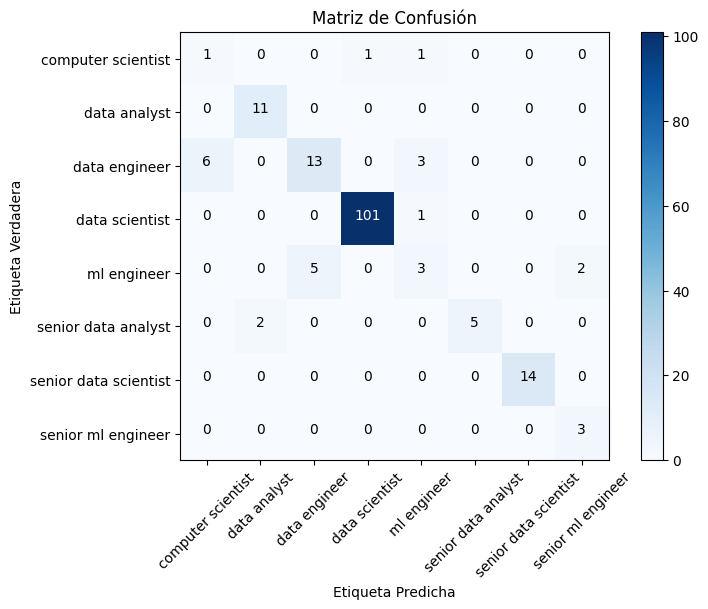

In [108]:
# Inicializamos el modelo de árbol de decisión
decision_tree_model= DecisionTreeClassifier(random_state=seed)

# Ajustamos el modelo a los datos de entrenamiento
decision_tree_model.fit(X_train, y_train)

# Calculamos y mostramos el rendimiento del modelo de árbol de decisión en el conjunto de entrenamiento
score_tree = decision_tree_model.score(X_train, y_train)
print(f"Rendimiento del modelo de árbol de decisión en el conjunto de entrenamiento: {score_tree:.4f}")

# Predecimos las etiquetas en el conjunto de prueba
y_pred_dt = decision_tree_model.predict(X_test)

# Calculamos la puntuación de precisión
accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Rendimiento del modelo de árbol de decisión en el conjunto de prueba: {accuracy}")

# Imprimimos un informe de clasificación detallado
print("Informe de clasificación:")
print(classification_report(y_test, y_pred_dt))

# Mostramos la matriz de confusión
conf_matrix_dt = plot_confusion_matrix(y_test, y_pred_dt)


### 2.2.2. Modelo de Random Forest

Un solo árbol de decisión puede ser muy sensible a los datos de entrenamiento (es decir, puede sobreajustar los datos), pero al combinar varios árboles, que es lo que hace Random Forest, se pueden suavizar estas variaciones y obtener mejores predicciones.

La relación básica entre un árbol de decisión y un bosque aleatorio es la siguiente:

Árbol de decisión: Es un clasificador que se construye utilizando el conjunto de datos completo, y toma decisiones basadas en las características del conjunto de datos. Aunque puede ser muy poderoso, un solo árbol de decisión suele tener una alta varianza y puede sobreajustarse fácilmente.

Random Forest: Es un ensamble de muchos árboles de decisión. Cada árbol se entrena en un subconjunto diferente de los datos y características, y sus predicciones se combinan para producir un resultado más robusto y preciso.

Una característica clave de Random Forest es el **Bagging**, que consiste en generar múltiples subconjuntos aleatorios del conjunto de datos de entrenamiento mediante muestreo con reemplazo (bootstrap). Cada árbol en el bosque se entrena en un subconjunto diferente de los datos de entrenamiento.
Muestreo con reemplazo: Significa que algunas observaciones pueden aparecer varias veces en el mismo subconjunto de entrenamiento, mientras que otras observaciones pueden no aparecer en absoluto.


In [109]:
from sklearn.ensemble import RandomForestClassifier

Rendimiento del modelo de Random Forest en el conjunto de entrenamiento: 1.0000
Rendimiento del modelo de Random Forest en el conjunto de prueba: 0.936046511627907
Informe de clasificación para Random Forest:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00        11
           3       0.74      0.91      0.82        22
           4       0.98      1.00      0.99       102
           5       0.60      0.30      0.40        10
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00        14
           8       1.00      0.67      0.80         3

    accuracy                           0.94       172
   macro avg       0.92      0.82      0.85       172
weighted avg       0.93      0.94      0.93       172



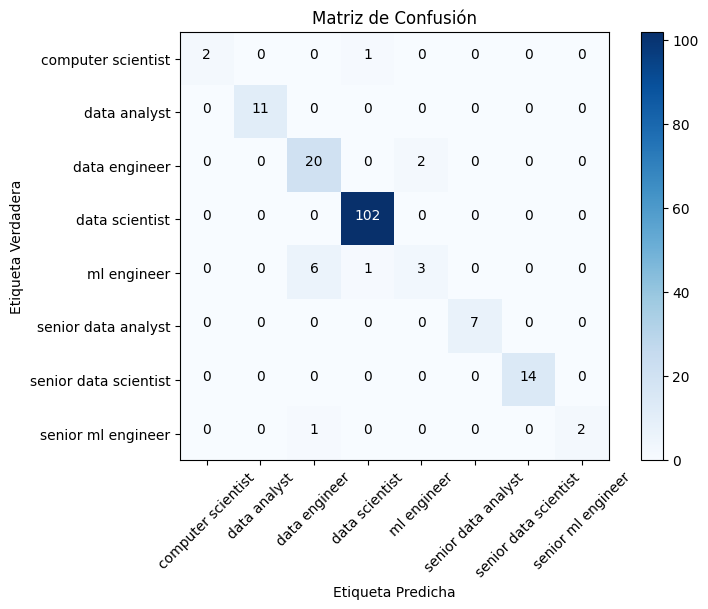

In [110]:
# Inicializamos el modelo de Random Forest
random_forest_model = RandomForestClassifier(random_state=seed)

# Ajustamos el modelo a los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Calculamos el rendimiento del modelo de Random Forest en el conjunto de entrenamiento
score_rf = random_forest_model.score(X_train, y_train)
print(f"Rendimiento del modelo de Random Forest en el conjunto de entrenamiento: {score_rf:.4f}")

# Predecimos las etiquetas en el conjunto de prueba
y_pred_rf = random_forest_model.predict(X_test)

# Calculamos la puntuación de precisión
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Rendimiento del modelo de Random Forest en el conjunto de prueba: {accuracy_rf}")

# Imprimimos un informe de clasificación detallado
print("Informe de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Mostramos la matriz de confusión
conf_matrix_rf = plot_confusion_matrix(y_test, y_pred_rf)

### 2.2.2. Modelo de Gradient Boosting

Gradient Boosting emplea un enfoque diferente a Random Forest, una de sus características principales es el concepto de boosting.

El término **boosting** se refiere a un proceso en el que los modelos se construyen secuencialmente, de manera que cada modelo nuevo se enfoca en corregir los errores cometidos por los modelos anteriores. A diferencia del bagging (utilizado en Random Forest), donde los modelos se entrenan de manera independiente y luego se combinan, el boosting crea modelos uno tras otro, y cada nuevo modelo está influido por el rendimiento de los anteriores.

In [111]:
from sklearn.ensemble import GradientBoostingClassifier

Rendimiento del modelo de Gradient Boosting en el conjunto de entrenamiento: 1.0000
Rendimiento del modelo de Gradient Boosting en el conjunto de prueba: 0.9012
Informe de clasificación para Gradient Boosting:
              precision    recall  f1-score   support

           1       0.33      0.67      0.44         3
           2       1.00      0.91      0.95        11
           3       0.74      0.77      0.76        22
           4       0.95      1.00      0.98       102
           5       0.60      0.30      0.40        10
           6       1.00      1.00      1.00         7
           7       1.00      0.86      0.92        14
           8       1.00      0.67      0.80         3

    accuracy                           0.90       172
   macro avg       0.83      0.77      0.78       172
weighted avg       0.90      0.90      0.90       172



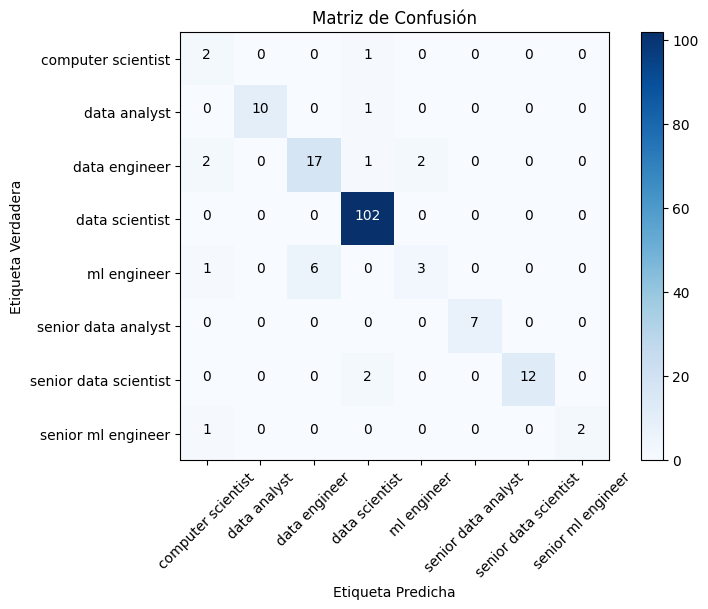

In [112]:
# Inicializamos el modelo de Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier(random_state=seed)

# Ajustamos el modelo a los datos de entrenamiento
gradient_boosting_model.fit(X_train, y_train)

# Calculamos el rendimiento del modelo de Gradient Boosting en el conjunto de entrenamiento
score_gb = gradient_boosting_model.score(X_train, y_train)
print(f"Rendimiento del modelo de Gradient Boosting en el conjunto de entrenamiento: {score_gb:.4f}")

# Predecimos las etiquetas en el conjunto de prueba
y_pred_gb = gradient_boosting_model.predict(X_test)

# Calculamos la puntuación de precisión
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Rendimiento del modelo de Gradient Boosting en el conjunto de prueba: {accuracy_gb:.4f}")

# Imprimimos un informe de clasificación detallado
print("Informe de clasificación para Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

# Mostramos la matriz de confusión
conf_matrix_gb = plot_confusion_matrix(y_test, y_pred_gb)


## Análisis de características

Veamos la importancia de cada característica para cada modelo:

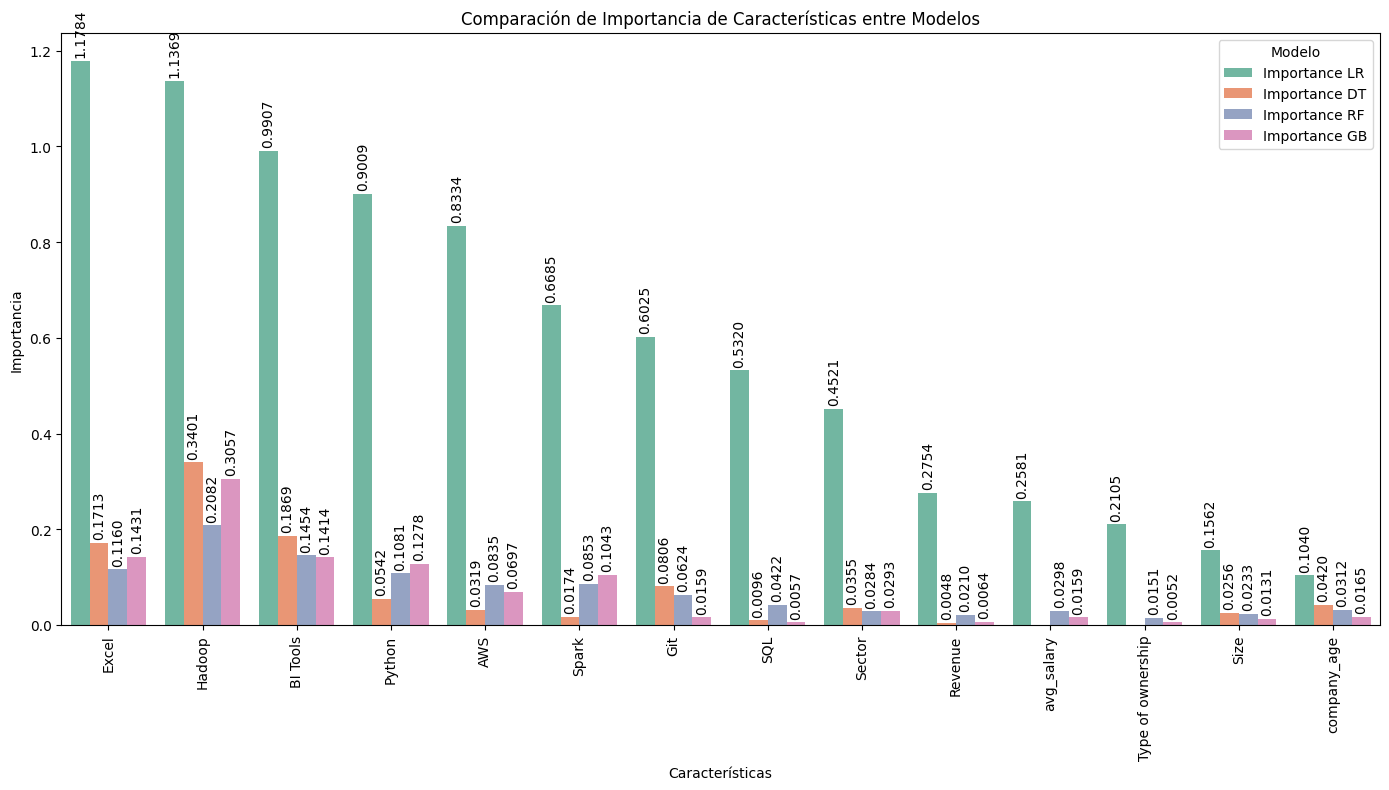

In [113]:
#Dado que regresión logística tenemos un conjunto de coeficientes por cada clase, promediamos los coeficientes para cada característica.
importances_lr = np.mean(np.abs(logistic_regression_model.coef_), axis=0)
importances_dt = decision_tree_model.feature_importances_
importances_rf = random_forest_model.feature_importances_
importances_gb = gradient_boosting_model.feature_importances_

# Creamos un dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance LR': importances_lr,
    'Importance DT': importances_dt,
    'Importance RF': importances_rf,
    'Importance GB': importances_gb    
}).sort_values(by='Importance LR', ascending=False)

# Derretir el DataFrame para usarlo en Seaborn (de wide a long format)
melted_df = feature_importance_df.melt(id_vars="Feature", var_name="Model", value_name="Importance")

# Establecer el tamaño del gráfico
plt.figure(figsize=(14, 8))

# Crear el gráfico de barras usando Seaborn
ax = sns.barplot(x="Feature", y="Importance", hue="Model", data=melted_df, palette="Set2")

# Rotar las etiquetas del eje x para que no se superpongan
plt.xticks(rotation=90)

# Agregar título y etiquetas
plt.title('Comparación de Importancia de Características entre Modelos')
plt.xlabel('Características')
plt.ylabel('Importancia')

# Mostrar la leyenda
plt.legend(title='Modelo')

# Agregar los números encima de cada barra, colocándolos bien arriba
for p in ax.patches:
    height = p.get_height()  # Altura de la barra
    if height > 0:  # Evitar valores negativos o ceros
        ax.annotate(format(height, '.4f'),  # Formato para los números
                    (p.get_x() + p.get_width() / 2., height),  # Posición del texto (centrado horizontalmente)
                    ha='center', va='center',  # Alineación horizontal y vertical
                    xytext=(0, 20),  # Desplazamiento vertical para que quede bien arriba de la barra
                    textcoords='offset points', rotation=90)  # Rotación vertical del texto

# Ajustar el diseño del gráfico para evitar cortes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Analicemos la colinealidad entre columnas:

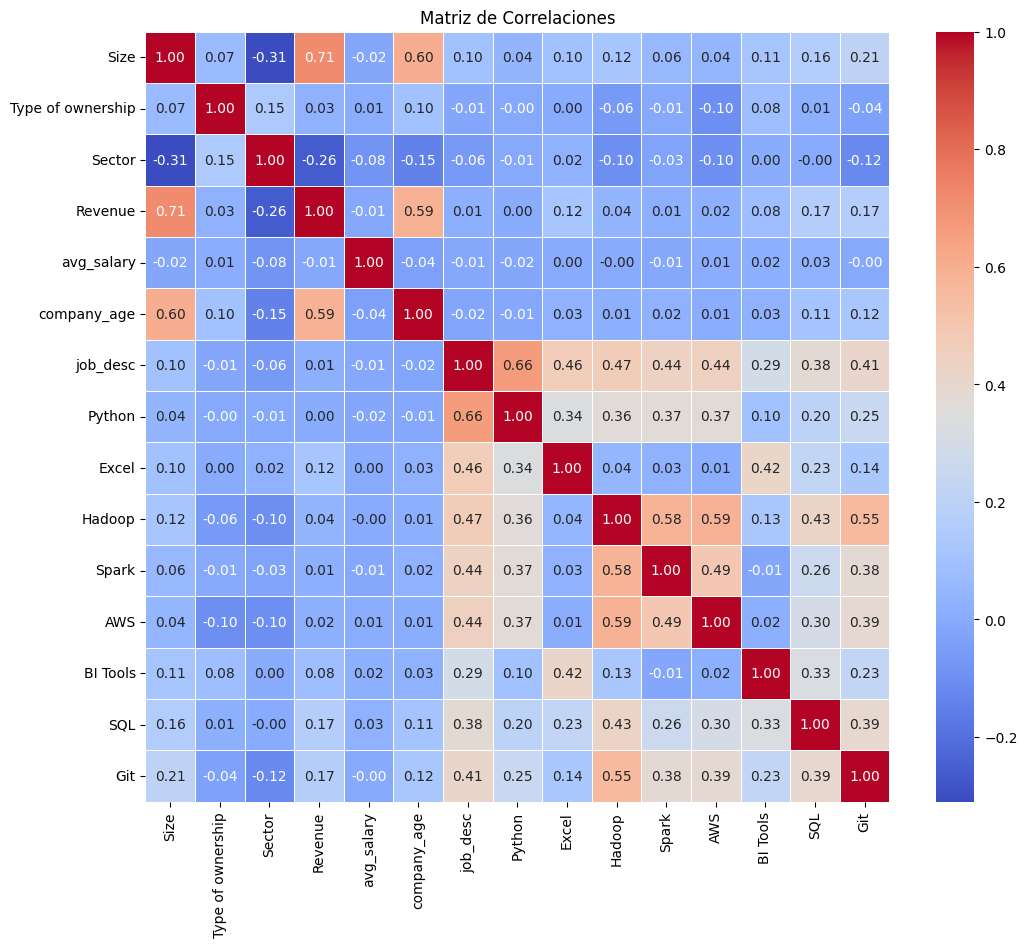

In [114]:
# Seleccionamos las variables numéricas
columnas_numericas = jb_encoded.select_dtypes(include=['number'])

# Calcular la matriz de correlaciones
matriz_correlaciones = columnas_numericas.corr()

# Crear un mapa de calor de la matriz de correlaciones
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlaciones, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlaciones')
plt.show()

INTERPRETACIÓN
Las características 'Size' y 'Revenue' son las que presentan una mayor correlación. Al analizar la importancia de cada una de ellas para todos los modelos, observamos que 'Size', parece tener un mayor peso en nuestros modelos de 'Árbol de decisión', 'Random Forest' y 'Gradient Boosting', contrariamente a la 'Regresión logística'. 

Por ello, a continuación, trateremos de evaluar, para cada modelo, si al extraer la variable 'Revenue', obtenemos mejores resultados.

In [115]:
#Para Arbol decisión, Random Forest y Gradient Boosting que no eran sensibles al escalado de características
X_train_reduced = X_train.drop(columns=['Revenue'])
X_test_reduced = X_test.drop(columns=['Revenue'])

#Para regresión logística, que nos daba un accuracy más elevado con datos escalados
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

##### Regresión logística

Rendimiento del modelo de regresión logística en el conjunto de entrenamiento: 0.9650
Rendimiento del modelo de regresión logística en el conjunto de prueba: 0.8953488372093024
Informe de clasificación Regresión logística:
              precision    recall  f1-score   support

           1       0.29      0.67      0.40         3
           2       0.91      0.91      0.91        11
           3       0.81      0.77      0.79        22
           4       0.93      0.99      0.96       102
           5       1.00      0.40      0.57        10
           6       1.00      0.57      0.73         7
           7       1.00      0.93      0.96        14
           8       1.00      1.00      1.00         3

    accuracy                           0.90       172
   macro avg       0.87      0.78      0.79       172
weighted avg       0.91      0.90      0.89       172



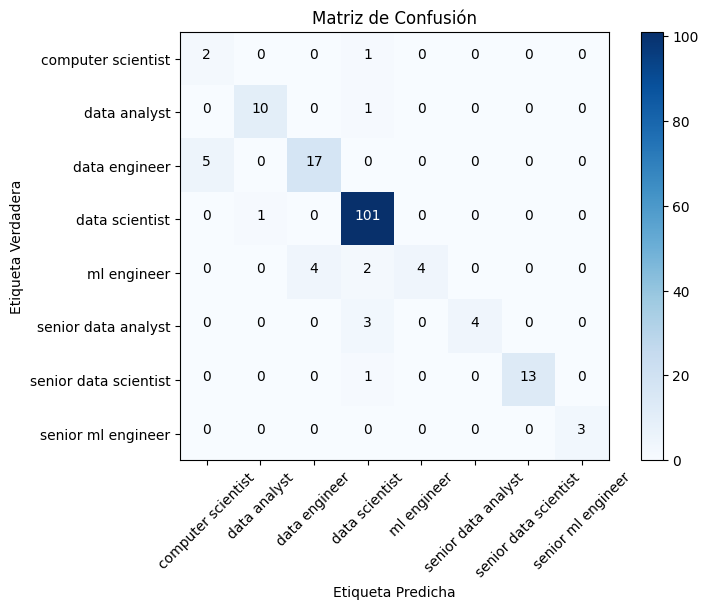

In [116]:
# Reentrenar el modelo con las características seleccionadas
logistic_regression_model.fit(X_train_reduced_scaled, y_train)

# Calculamos el rendimiento del modelo de regresión logística en el conjunto de entrenamiento escalado
score_logistic_scaled_reduced = logistic_regression_model.score(X_train_reduced_scaled, y_train)
print(f"Rendimiento del modelo de regresión logística en el conjunto de entrenamiento: {score_logistic_scaled_reduced:.4f}")

# Predecimos las etiquetas en el conjunto de prueba escalados
y_pred_reduced_lr = logistic_regression_model.predict(X_test_reduced_scaled)

# Calculamos la puntuación de precisión
accuracy_reduced_lr = accuracy_score(y_test, y_pred_reduced_lr)
print(f"Rendimiento del modelo de regresión logística en el conjunto de prueba: {accuracy_reduced_lr}")

print("Informe de clasificación Regresión logística:")
print(classification_report(y_test, y_pred_reduced_lr))

conf_matrix_lr_scaled_reduced = plot_confusion_matrix(y_test, y_pred_reduced_lr)

##### Árbol de decisión

Rendimiento del modelo de árbol de decisión en el conjunto de entrenamiento: 1.0000
Rendimiento del modelo de árbol de decisión en el conjunto de prueba: 0.877906976744186
Informe de clasificación Árbol decisión:
              precision    recall  f1-score   support

           1       0.22      0.67      0.33         3
           2       0.79      1.00      0.88        11
           3       0.71      0.55      0.62        22
           4       0.99      0.99      0.99       102
           5       0.50      0.30      0.38        10
           6       1.00      0.71      0.83         7
           7       1.00      1.00      1.00        14
           8       0.60      1.00      0.75         3

    accuracy                           0.88       172
   macro avg       0.73      0.78      0.72       172
weighted avg       0.89      0.88      0.88       172



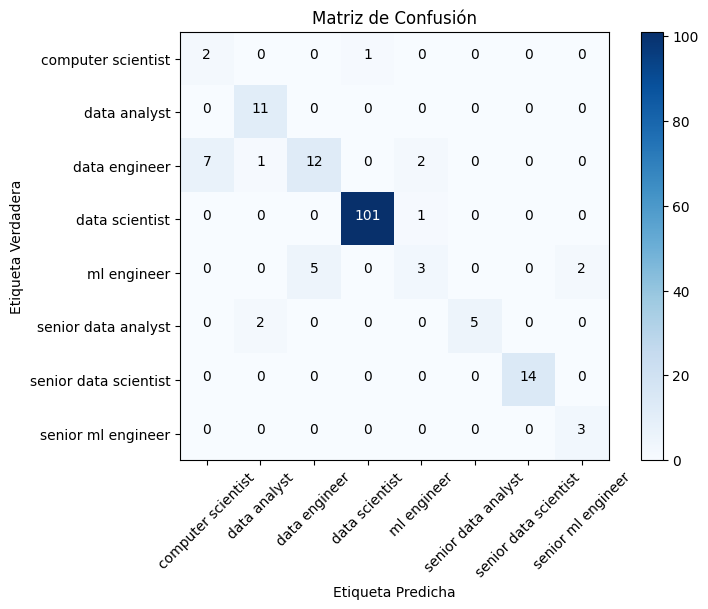

In [117]:
# Reentrenar el modelo con las características seleccionadas
decision_tree_model.fit(X_train_reduced, y_train)

# Calculamos el rendimiento del modelo en el conjunto de entrenamiento
score_tree_reduced = decision_tree_model.score(X_train_reduced, y_train)
print(f"Rendimiento del modelo de árbol de decisión en el conjunto de entrenamiento: {score_tree_reduced:.4f}")

# Predecimos las etiquetas en el conjunto de prueba escalados
y_pred_reduced_dt = decision_tree_model.predict(X_test_reduced)

# Calculamos la puntuación de precisión
accuracy_reduced_dt = accuracy_score(y_test, y_pred_reduced_dt)
print(f"Rendimiento del modelo de árbol de decisión en el conjunto de prueba: {accuracy_reduced_dt}")

print("Informe de clasificación Árbol decisión:")
print(classification_report(y_test, y_pred_reduced_dt))

conf_matrix_dt_reduced = plot_confusion_matrix(y_test, y_pred_reduced_dt)


##### Random Forest

Rendimiento del modelo de random forest en el conjunto de entrenamiento: 1.0000
Rendimiento de random forest en el conjunto de prueba: 0.936046511627907
Informe de clasificación Random Forest:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       1.00      1.00      1.00        11
           3       0.77      0.91      0.83        22
           4       0.97      1.00      0.99       102
           5       0.67      0.20      0.31        10
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00         3

    accuracy                           0.94       172
   macro avg       0.88      0.85      0.85       172
weighted avg       0.93      0.94      0.92       172



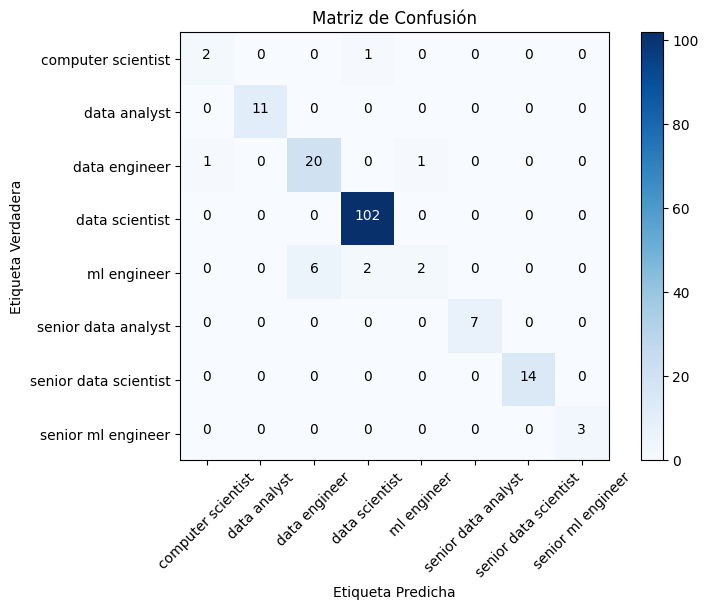

In [118]:
# Reentrenar el modelo con las características seleccionadas
random_forest_model.fit(X_train_reduced, y_train)

# Calculamos el rendimiento del modelo en el conjunto de entrenamiento
score_rf_reduced = random_forest_model.score(X_train_reduced, y_train)
print(f"Rendimiento del modelo de random forest en el conjunto de entrenamiento: {score_rf_reduced:.4f}")

# Predecimos las etiquetas en el conjunto de prueba
y_pred_reduced_rf = random_forest_model.predict(X_test_reduced)

# Calculamos la puntuación de precisión
accuracy_reduced_rf = accuracy_score(y_test, y_pred_reduced_rf)
print(f"Rendimiento de random forest en el conjunto de prueba: {accuracy_reduced_rf}")

print("Informe de clasificación Random Forest:")
print(classification_report(y_test, y_pred_reduced_rf))

conf_matrix_rf_reduced = plot_confusion_matrix(y_test, y_pred_reduced_rf)


##### Gradient Boosting

Rendimiento del modelo de gradient boosting en el conjunto de entrenamiento: 1.0000
Rendimiento de gradient boosting en el conjunto de prueba: 0.9244186046511628
Informe de clasificación Gradient Boosting:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       1.00      0.91      0.95        11
           3       0.73      0.86      0.79        22
           4       0.97      1.00      0.99       102
           5       0.67      0.40      0.50        10
           6       1.00      1.00      1.00         7
           7       1.00      0.93      0.96        14
           8       1.00      0.67      0.80         3

    accuracy                           0.92       172
   macro avg       0.88      0.80      0.83       172
weighted avg       0.92      0.92      0.92       172



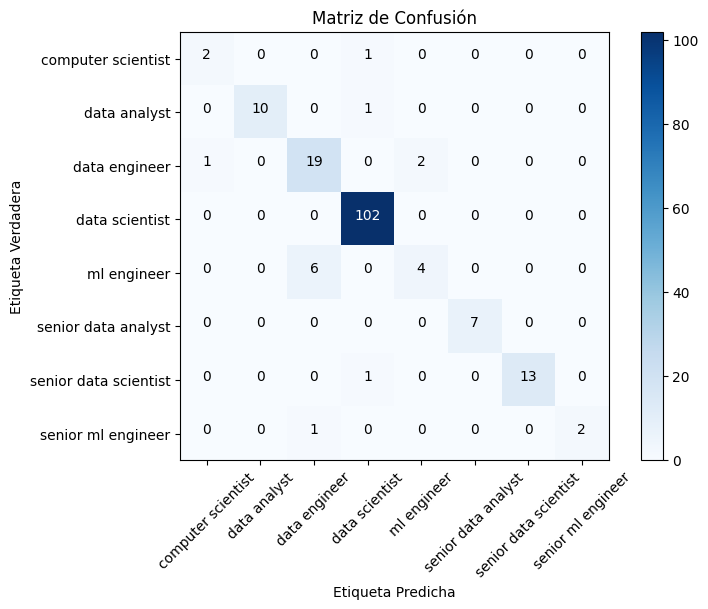

In [119]:
# Reentrenar el modelo con las características seleccionadas
gradient_boosting_model.fit(X_train_reduced, y_train)

# Calculamos el rendimiento del modelo en el conjunto de entrenamiento
score_gb_reduced = gradient_boosting_model.score(X_train_reduced, y_train)
print(f"Rendimiento del modelo de gradient boosting en el conjunto de entrenamiento: {score_gb_reduced:.4f}")

# Predecimos las etiquetas en el conjunto de prueba
y_pred_reduced_gb = gradient_boosting_model.predict(X_test_reduced)

## Calculamos la puntuación de precisión
accuracy_reduced_gb = accuracy_score(y_test, y_pred_reduced_gb)
print(f"Rendimiento de gradient boosting en el conjunto de prueba: {accuracy_reduced_gb}")

print("Informe de clasificación Gradient Boosting:")
print(classification_report(y_test, y_pred_reduced_gb))

conf_matrix_gb_reduced = plot_confusion_matrix(y_test, y_pred_reduced_gb)


#### Conclusión del análisis de características

Al haber eliminado 'Revenue', observamos como la precisión de los modelos 'Árbol de decisión', 'Random Forest' y 'Gradient Boosting' se ha mantenido igual en los dos primeros modelos, mientras que ha incrementado en el último, contrariamente a la 'Regresión logística', que ha disminuido. 

Como en los primeros modelos hemos obtenidos resultados más elevados, obtamos por eliminar esta columna a partir de ahora.

In [120]:
#Separamos nuestra variables características de nuestra variable objetivo
X = jb_encoded.drop(columns=['job_desc','Revenue'])
y = jb_encoded['job_desc']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(400, 13) (172, 13) (400,) (172,)


### Validación cruzada

La validación cruzada es un método fundamental en el aprendizaje automático para evaluar cómo los resultados de un análisis estadístico se generalizarán a un conjunto de datos independiente. A continuación, utilizaremos esta técnica para los 4 modelos creados anteriormente.

In [121]:
from sklearn import model_selection

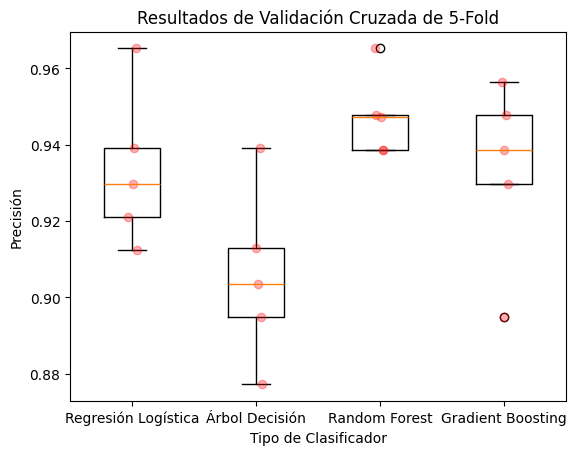

In [126]:
# Inicializar una matriz para almacenar los puntajes de precisión para cada pliegue y modelo
acc = np.zeros((5, 4))  # 5 pliegues, 4 modelos

# Crear un objeto KFold para validación cruzada de 5-fold
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)

# Contador de bucle
i = 0

# Iterar sobre cada pliegue definido por KFold
for train_index, test_index in kf.split(X):
    # Dividir los datos en conjuntos de entrenamiento y prueba basados en el pliegue actual
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inicializar clasificadores
    rl = LogisticRegression(max_iter=9000)
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    gb = GradientBoostingClassifier()  # Árbol de decisión
    
    # Entrenar cada clasificador en el conjunto de entrenamiento
    rl.fit(X_train, y_train)
    dt.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    yhat_rl = rl.predict(X_test)
    yhat_dt = dt.predict(X_test)
    yhat_rf = rf.predict(X_test)
    yhat_gb = gb.predict(X_test)
    
    # Calcular y almacenar la precisión para cada clasificador
    acc[i][0] = metrics.accuracy_score(yhat_rl, y_test)
    acc[i][1] = metrics.accuracy_score(yhat_dt, y_test)
    acc[i][2] = metrics.accuracy_score(yhat_rf, y_test)
    acc[i][3] = metrics.accuracy_score(yhat_gb, y_test)
    
    # Incrementar el contador del bucle
    i += 1

# Visualizar los puntajes de precisión como un gráfico de caja para cada clasificador
plt.boxplot(acc)

# Superponer los puntajes individuales de precisión como puntos rojos para una mejor visualización
for i in range(4):
    xderiv = (i+1) * np.ones(acc[:, i].shape) + (np.random.rand(5,) - 0.5) * 0.1
    plt.plot(xderiv, acc[:, i], 'ro', alpha=0.3)

# Configurar las etiquetas para cada clasificador en el eje x
ax = plt.gca()
ax.set_xticklabels(['Regresión Logística', 'Árbol Decisión', 'Random Forest', 'Gradient Boosting'])

plt.xlabel('Tipo de Clasificador')
plt.ylabel('Precisión')
plt.title('Resultados de Validación Cruzada de 5-Fold')

plt.show()

In [127]:
# Calcular las medias de precisión para cada modelo
mean_acc = np.mean(acc, axis=0)

# Imprimir las medias de precisión
model_names = ['Regresión Logística', 'Árbol de Decisión', 'Random Forest', 'Gradient Boosting']
for i, model_name in enumerate(model_names):
    print(f"Precisión media para {model_name}: {mean_acc[i]:.4f}")

Precisión media para Regresión Logística: 0.9335
Precisión media para Árbol de Decisión: 0.9055
Precisión media para Random Forest: 0.9475
Precisión media para Gradient Boosting: 0.9335


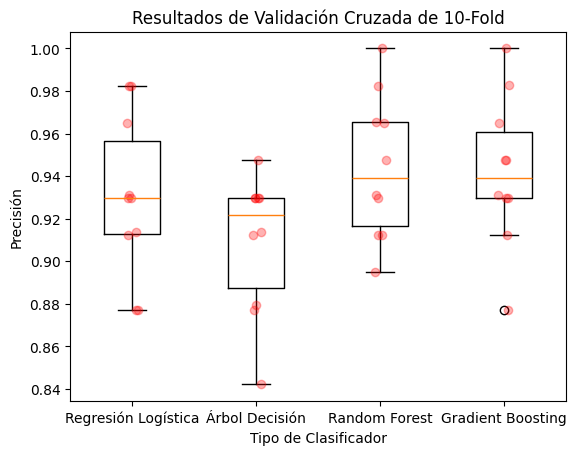

In [163]:
# Inicializar una matriz para almacenar los puntajes de precisión para cada pliegue y modelo
acc = np.zeros((10, 4))  # 10 pliegues, 4 modelos

# Crear un objeto KFold para validación cruzada de 10-fold
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

# Contador de bucle
i = 0

# Iterar sobre cada pliegue definido por KFold
for train_index, test_index in kf.split(X):
    # Dividir los datos en conjuntos de entrenamiento y prueba basados en el pliegue actual
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Inicializar clasificadores
    rl = LogisticRegression(max_iter=9000)
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    gb = GradientBoostingClassifier()  # Árbol de decisión
    
    # Entrenar cada clasificador en el conjunto de entrenamiento
    rl.fit(X_train, y_train)
    dt.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    yhat_rl = rl.predict(X_test)
    yhat_dt = dt.predict(X_test)
    yhat_rf = rf.predict(X_test)
    yhat_gb = gb.predict(X_test)
    
    # Calcular y almacenar la precisión para cada clasificador
    acc[i][0] = metrics.accuracy_score(yhat_rl, y_test)
    acc[i][1] = metrics.accuracy_score(yhat_dt, y_test)
    acc[i][2] = metrics.accuracy_score(yhat_rf, y_test)
    acc[i][3] = metrics.accuracy_score(yhat_gb, y_test)
    
    # Incrementar el contador del bucle
    i += 1

# Visualizar los puntajes de precisión como un gráfico de caja para cada clasificador
plt.boxplot(acc)

# Superponer los puntajes individuales de precisión como puntos rojos para una mejor visualización
for i in range(4):
    xderiv = (i+1) * np.ones(acc[:, i].shape) + (np.random.rand(10,) - 0.5) * 0.1
    plt.plot(xderiv, acc[:, i], 'ro', alpha=0.3)

# Configurar las etiquetas para cada clasificador en el eje x
ax = plt.gca()
ax.set_xticklabels(['Regresión Logística', 'Árbol Decisión', 'Random Forest', 'Gradient Boosting'])

plt.xlabel('Tipo de Clasificador')
plt.ylabel('Precisión')
plt.title('Resultados de Validación Cruzada de 10-Fold')

plt.show()

In [164]:
# Calcular las medias de precisión para cada modelo
mean_acc = np.mean(acc, axis=0)

# Imprimir las medias de precisión
model_names = ['Regresión Logística', 'Árbol de Decisión', 'Random Forest', 'Gradient Boosting']
for i, model_name in enumerate(model_names):
    print(f"Precisión media para {model_name}: {mean_acc[i]:.4f}")

Precisión media para Regresión Logística: 0.9301
Precisión media para Árbol de Decisión: 0.9091
Precisión media para Random Forest: 0.9440
Precisión media para Gradient Boosting: 0.9423


**EVALUACIÓN DE RESULTADOS**

10-Folds divide los datos en más subconjuntos, permite que el modelo sea evaluado más exhaustivamente. Esto puede generar una mejor estimación de cómo se comportará el modelo en datos no vistos. En este caso, vemos que al realizar los 10-Folds, las medias de los cuatros modelos tienden unirse.

En los diagramas de caja, podemos observar una reducción en la varianza y una mejor estimación del rendimiento medio.

Con estos resultados, decidimos escoger el modelo de **Random Forest** y **Gradient Boosting** que tiene una media más elevada y una varianza con valores más elevados.

El Random Forest, siendo un ensamblaje de múltiples árboles de decisión, tiende a ser más robusto frente a los datos de entrenamiento, ya que promedia los resultados de múltiples árboles y reduce la varianza del modelo.
Esto le permite manejar mejor los datos ruidosos y es menos propenso al sobreajuste en comparación con modelos individuales como los árboles de decisión.

Aunque la Regresión Logística y el Árbol de Decisión son modelos valiosos, pueden no capturar la complejidad y las interacciones en los datos tan bien como el Random Forest. La Regresión Logística es más adecuada para relaciones lineales, mientras que el Árbol de Decisión puede ser susceptible al sobreajuste.
El Gradient Boosting también es un modelo poderoso, pero puede ser más sensible a los parámetros de ajuste y al tiempo de entrenamiento, lo que podría haber influido en su rendimiento en esta prueba específica.

### Validación de hiperparámetros de Random Forest con GridSearchCV

¿Podemos mejorar más aún la precisión de Random Forest?
A continuación, mediante un análisis de hiperparámetros con GridSearchCV, trataremos de encontrar los mejores parámetros.

Grid Search es una técnica muy poderosa para ajustar hiperparámetros en modelos de machine learning. Aunque puede ser costosa en términos de tiempo y recursos, ofrece una forma sistemática y exhaustiva de encontrar los mejores hiperparámetros para maximizar el rendimiento del modelo.

In [80]:
from sklearn.model_selection import GridSearchCV

In [137]:
# Inicializar el modelo de Random Forest
random_forest_model = RandomForestClassifier()

# Configurar los hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'n_estimators': [25,50, 100, 150, 200],   # Número de árboles
    'max_depth': [None, 10, 20, 30],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],        # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de muestras en una hoja
    'criterion': ['gini', 'entropy']        # Criterio de división: Gini o Entropía
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, 
                           cv=9, n_jobs=-1, verbose=0, scoring='accuracy')

# Ejecutar GridSearchCV en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y la mejor puntuación
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

# Usar el mejor modelo para hacer predicciones en el conjunto de prueba
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación de validación cruzada:
0.9417893392485044
Precisión en el conjunto de prueba: 0.9298


In [140]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Inicializar el modelo de Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier(random_state=seed)

# Configurar los hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'n_estimators': [50, 100, 150],   # Número de árboles en el modelo de boosting
    'learning_rate': [0.01, 0.1, 0.2],      # Tasa de aprendizaje
    'max_depth': [3, 5, 7],                 # Profundidad máxima de los árboles
    'subsample': [0.8, 0.9, 1.0],           # Fracción de muestras usadas para ajustar cada árbol
    'criterion': ['friedman_mse', 'squared_error']  # Criterio de división
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=gradient_boosting_model, param_grid=param_grid, 
                           cv=9, n_jobs=-1, verbose=0, scoring='accuracy')

# Ejecutar GridSearchCV en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y la mejor puntuación
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

# Usar el mejor modelo para hacer predicciones en el conjunto de prueba
best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

Mejores parámetros encontrados:
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
Mejor puntuación de validación cruzada:
0.9456543657995563
Precisión en el conjunto de prueba: 0.8596


### Evaluación de nuestro modelo con datos reales

Generamos 4 registros con datos reales de ofertas de trabajo actuales para tratar de predecir el perfil profesional.

In [157]:
real_data = pd.DataFrame({
    'Size': [2, 2, 7, 7],
    'Type of ownership': [1, 1, 1, 1],
    'Sector': [6, 6, 4, 3],
    'avg_salary': [70, 90, 150, 100],
    'company_age': [30, 30, 120, 35],
    'Python': [2, 1, 6, 3],
    'Excel': [2, 5, 6, 2],
    'Hadoop': [2, 0, 6, 3],
    'Spark': [2, 1, 6, 3],
    'AWS': [2, 0, 6, 3],
    'BI Tools': [2, 2, 6, 0],
    'SQL': [0, 2, 6, 1],
    'Git': [1, 1, 6, 3]
})

real_y= [
    'data engineer',
    'data analyst',
    'senior data scientist',
    'ml engineer',
]

##### Random Forest

In [162]:
# Realizar predicciones con el mejor modelo encontrado
predictiones_rf = best_rf.predict(real_data)

# Invertir el diccionario para que los números sean las claves
mapeo_invertido = {v: k for k, v in mapeo_categorias_le['job_desc'].items()}

# Mapear los números a sus descripciones correspondientes
predictiones_mapeadas_rf = [mapeo_invertido[num] for num in predictiones_rf]

# Mostrar las descripciones mapeadas
print("Descripciones mapeadas:", predictiones_mapeadas_rf)
print("Descripciones reales:", real_y)

Descripciones mapeadas: ['data engineer', 'data analyst', 'senior data scientist', 'data engineer']
Descripciones reales: ['data engineer', 'data analyst', 'senior data scientist', 'ml engineer']


##### Gradient Boosting

In [159]:
# Realizar predicciones con el mejor modelo encontrado
predictions_gb = best_gb.predict(real_data)

# Invertir el diccionario para que los números sean las claves
mapeo_invertido = {v: k for k, v in mapeo_categorias_le['job_desc'].items()}

# Mapear los números a sus descripciones correspondientes
descripciones_mapeadas = [mapeo_invertido[num] for num in predictions_gb]

# Mostrar las descripciones mapeadas
print("Descripciones predichas:", descripciones_mapeadas)
print("Descripciones reales:", real_y)

Descripciones predichas: ['data engineer', 'data analyst', 'senior data scientist', 'data engineer']
Descripciones reales: ['data engineer', 'data analyst', 'senior data scientist', 'ml engineer']
